## ch04 Tree Creation
- https://github.com/mattharrison/effective_xgboost_book/blob/main/xgbcode.ipynb

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.7.18</div>
<div style="text-align: right"> Last update: 2023.7.18</div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

### 4.1 The Gini Coefficient

지니계수는 빈도 분포에서 불평등 레벨을 계량화 한것이다.  
- 0 : 완전 평등  
- 1 : 값들 간 최대의 불평등  

$$Gini = 1 - \sum_{i=1}^{c}{p_{i}^2}$$

- 위에서 c는 클래스의 수이다.  
- pi는 클래스 i의 관측 비율이다.

최적의 트리 splitting을 이해하기 위해 두개 클래스와 2개 피처를 가지는 데이터셋을 만들어 실험한다.  
일부 피처 클래스가 겹친다. 즉 트리 분할 양쪽 모두에 클래스 관측 값이 있다.   

우리는 올바를 클래스로 나누는 피처 threshold를 찾아본다.

두개의 랜덤 변수를 만들고 positive, negative로 레이블링 해보자.

In [2]:
import numpy as np
import numpy.random as rn

In [3]:
pos_center = 12
pos_count = 100
neg_center = 7
neg_count = 1000
rs = rn.RandomState(rn.MT19937(rn.SeedSequence(42)))

In [4]:
gini = pd.DataFrame(
    {
        'value': np.append((pos_center) + rs.randn(pos_count), (neg_center) + rs.randn(neg_count)),
        'label': ['pos']*pos_count + ['neg']*neg_count
    }
)

In [5]:
gini

,value,label
0,14.210352,pos
1,12.775662,pos
2,12.346531,pos
3,12.977911,pos
4,13.146511,pos
...,...,...
1095,6.633856,neg
1096,6.116057,neg
1097,6.586057,neg
1098,6.990318,neg


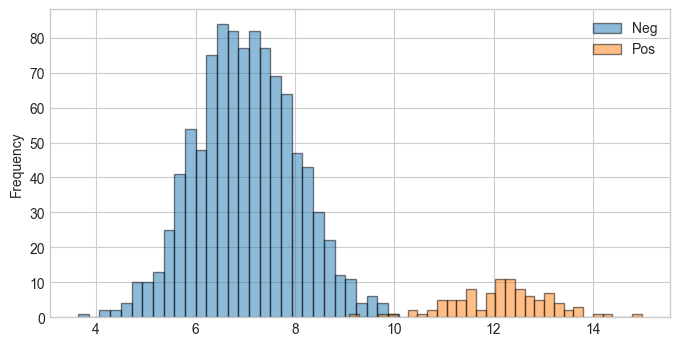

In [6]:
fig, ax = plt.subplots(figsize = (8, 4))

_ = (gini
     .groupby('label')
     [['value']]
     .plot.hist(bins = 30, alpha = .5, ax = ax, edgecolor = 'black')
     )
ax.legend(['Neg', 'Pos'])

- 9 ~ 10 사이에 오버랩이 있다.

이제 피처를 보고 값이 pos, neg 인지 결정해야 한다고 가정해보자.  
지니계수가 도움이 될 수 있다.  
지니계수를 계산하려면 pos, neg 결정 지점(split_point)를 고려해야한다.   


실제 레이블이 있으면, true positive, false positive, true negative, and false negative를 계한할 수 있다.  
그런 다음 1에서 TP와 FP의 비율을 제곱한 값을 뺀 가중 평균을 계산합니다.   
또한 가중 평균에서 1을 뺸 값에서 TP, FP의 비율의 제곱을 계산한다.    

이 두 값의 가중 평균이 지니계수이다.

In [7]:
def calc_gini(df, val_col, label_col, pos_val, split_point, debug=False):
    """
    This function calculates the Gini impurity of a dataset. Gini impurity 
    is a measure of the probability of a random sample being classified 
    incorrectly when a feature is used to split the data. The lower the 
    impurity, the better the split.

    Parameters:
    df (pd.DataFrame): The dataframe containing the data
    val_col (str): The column name of the feature used to split the data
    label_col (str): The column name of the target variable
    pos_val (str or int): The value of the target variable that represents 
        the positive class
    split_point (float): The threshold used to split the data.
    debug (bool): optional, when set to True, prints the calculated Gini
        impurities and the final weighted average

    Returns:
    float: The weighted average of Gini impurity for the positive and 
        negative subsets.
    """
    ge_split = df[val_col] >= split_point
    eq_pos = df[label_col] == pos_val
    tp = df[ge_split & eq_pos].shape[0]
    fp = df[ge_split & ~eq_pos].shape[0]
    tn = df[~ge_split & ~eq_pos].shape[0]
    fn = df[~ge_split & eq_pos].shape[0]
    pos_size = tp+fp
    neg_size = tn+fn
    total_size = len(df)
    if pos_size == 0:
        gini_pos = 0
    else:
        gini_pos = 1 - (tp/pos_size)**2 - (fp/pos_size)**2
    if neg_size == 0:
        gini_neg = 0
    else:
        gini_neg = 1 - (tn/neg_size)**2 - (fn/neg_size)**2
    weighted_avg = gini_pos * (pos_size/total_size) + \
                   gini_neg * (neg_size/total_size)
    if debug:
        print(f'{gini_pos=:.3} {gini_neg=:.3} {weighted_avg=:.3}')
    return weighted_avg

In [8]:
calc_gini(df = gini, val_col='value', label_col='label', pos_val='pos', split_point=9.24, debug=True)

gini_pos=0.217 gini_neg=0.00202 weighted_avg=0.0241


0.024117224644432264

분할 계산을 반복하여 gini 인덱스를 계산하고 차트를 그려보자.

In [9]:
values = np.arange(5, 15, 0.1)
ginis = []

for v in values:
    ginis.append(calc_gini(gini, val_col='value', label_col='label',
                           pos_val='pos', split_point=v
                           ))
    
print(ginis)

[0.16496756255792394, 0.16488911460978492, 0.16473000683526995, 0.16468168965812685, 0.16458423093494176, 0.16435245830058498, 0.16420014094432692, 0.1638163816381637, 0.16345270890725436, 0.1628984958849684, 0.16245522315809854, 0.1619906810746506, 0.16150330116810563, 0.16087138667783812, 0.1598859524070622, 0.15886134067952254, 0.15770436460091622, 0.1562819203268641, 0.15484219045049905, 0.1532304173813607, 0.15146456214903628, 0.14946619217081844, 0.14731757805761594, 0.14456035767511174, 0.1414141414141414, 0.1382166993677785, 0.13495782567947517, 0.13045711350796096, 0.12428078250863063, 0.11779769526248399, 0.11346548188653453, 0.10760667903525044, 0.10064935064935064, 0.09355692850838483, 0.08406647116324537, 0.07486631016042782, 0.06746712407089767, 0.05979255643685174, 0.05006587615283267, 0.046132971506105826, 0.03865425912670007, 0.03575074896607636, 0.028195644417259164, 0.02270919869604089, 0.019816345270890757, 0.01527429474460562, 0.013703145114253214, 0.01047020248827

Text(0.5, 0, 'Split Point')

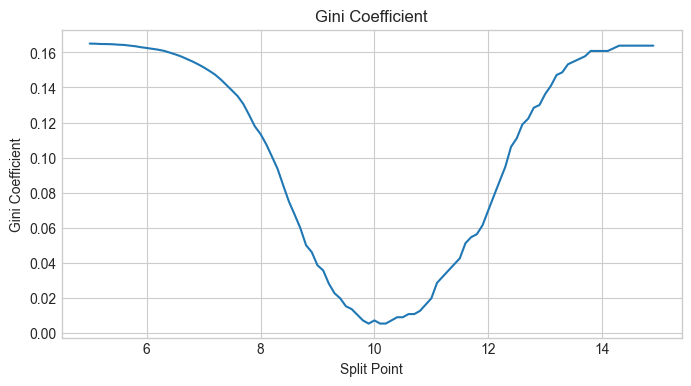

In [10]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(values, ginis)
ax.set_title('Gini Coefficient')
ax.set_ylabel('Gini Coefficient')
ax.set_xlabel('Split Point')

최소 값이 10 근처에서 형성되는 것을 알 수있다.

In [11]:
pd.Series(ginis, index = values).loc[9.5:10.5]

9.6     0.013703
9.7     0.010470
9.8     0.007193
9.9     0.005429
10.0    0.007238
10.1    0.005438
10.2    0.005438
10.3    0.007244
10.4    0.009046
10.5    0.009046
dtype: float64

In [12]:
print(pd.DataFrame({'gini':ginis, 'split':values})\
    .query('gini <= gini.min()'))

        gini  split
49  0.005429    9.9


### 4.2 Coefficients in Trees

이제 하나의 노드면 있는 트리를 만들어 보자.  
이 것을 decision stump라고 한다. 줄기가 없는...

In [13]:
from sklearn import tree

stump = tree.DecisionTreeClassifier(max_depth=1)
stump.fit(gini[['value']], gini.label)

DecisionTreeClassifier(max_depth=1)

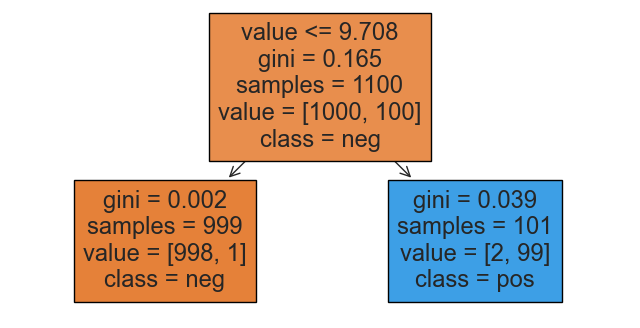

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))
tree.plot_tree(stump, feature_names=['value'],
               filled=True, 
               class_names=stump.classes_,
               ax=ax)
plt.show()

- 위 결과와 거의 비슷한 결과를 얻었다.

In [15]:
gini_pos = 0.039
gini_neg = 0.002
pos_size = 101
neg_size = 999
total_size = pos_size + neg_size
weighted_avg = gini_pos * (pos_size/total_size) + gini_neg * (neg_size/total_size)
print(weighted_avg)

0.005397272727272727


XGBoost는 Gini를 사용하지 않는다. 그러나 Sklearn은 디펄트로 사용한다????   
XGBoost가 트리를 구축하고 학습한 후 두 통계치 gi, hi를 계산한다.  
이 값은 지니와 유사하며, loss function의 추이를 내는 효과를 보인다.   

gradient(gi)는 각 인스턴스의 예측 값에 대한 손실 함수의 첫 번째 도함수를 나타내며, 두 번째 derivative(hi)는 손실 함수의 곡률(curvature)을 나타냅니다.

max_depth와 n_estimators를 제한하여 xgboost stump를 만들어보자.

In [16]:
import xgboost as xgb

xg_stump = xgb.XGBClassifier(n_estimators = 1, max_depth = 1)
xg_stump.fit(gini[['value']], (gini.label =='pos'))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

<Axes: >

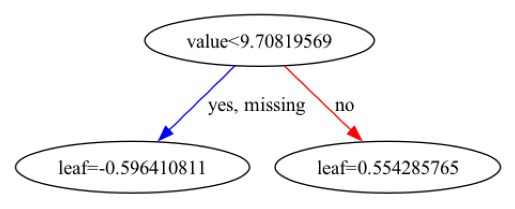

In [17]:
xgb.plot_tree(xg_stump, num_trees=0)

- leaf의 값이 다르긴한데, 뒤에서 설명

### 4.3 Another Visualization Tool

In [18]:
import dtreeviz

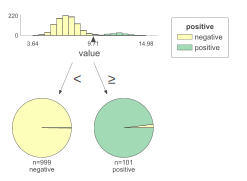

In [19]:
viz = dtreeviz.model(xg_stump, X_train=gini[['value']],
                     y_train=gini.label=='pos',
                     target_name='positive',
                     feature_names=['value'], class_names=['negative', 'positive'],
                     tree_index=0)
viz.view()